In [254]:
# Zavier Morales
# Edouard Mason
from pathlib import Path
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.dummy import DummyClassifier
from scipy.stats import loguniform
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# Define global variables & import data

RANDOM_STATE_ID = 100577770

TRAINING_DATA_PATH = Path('dataset', 'bank_06.pkl')
COMPETITION_DATA_PATH = Path('dataset', 'bank_competition.pkl')

training_times = {}
tuning_times = {}
prediction_times = {}

raw_data = pd.read_pickle(TRAINING_DATA_PATH)


<div style= "font-family: 'Georgia', serif;" >

## **EDA**

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

Our goal in EDA is to ensure the following about our dataset:

<br>

- All variables are in numerical format.
- There are no missing values in our dataset.
- Our dataset is well balanced (this is a classification problem since we are predicting whether a customer will subscribe or not)



In [ ]:

# quick look at our dataset to help us determine what to do first (probably convert categorical to numerical)
print("Shape of the dataset:\n", raw_data.shape)
print("\nFirst few rows:\n",raw_data.head())
print("\nList of columns:\n",raw_data.columns)
print("\n\n\nTarget variable:\n",raw_data['deposit'].head())


Shape of the dataset:
 (11000, 17)

First few rows:
    age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  

List of columns:
 Index(['age', 'job', 'marit

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

Here we are finding the cardinality & data types of variables in order to determine which variables are object-like vs already numerical

In [ ]:
#Cardinality of variables
unique_counts = raw_data.nunique()
print(unique_counts)
print(raw_data.dtypes)


age            76
job            12
marital         3
education       4
default         2
balance      3783
housing         2
loan            2
contact         3
day            31
month          12
duration     1423
campaign       36
pdays         472
previous       34
poutcome        4
deposit         2
dtype: int64


<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

We use one-hot encoding to create new columns for the categorical variables we just identified. We also check if there are any missing values per column, and luckily we find that there are none.

In [ ]:

# Encoding object-type variables (except for deposit, which is our target variable)
df_encoded = pd.get_dummies(raw_data, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'])
print(df_encoded)

#Converting all boolean columns to integers (1 for True, 0 for False)
df_encoded[df_encoded.select_dtypes(include=['bool']).columns] = df_encoded.select_dtypes(include=['bool']).astype(int)
print("\nColumns in the DataFrame:\n\n",df_encoded.columns)
print("\n\nFirst few rows of the DataFrame:\n\n",df_encoded.head())

#Checking the number of missing values per column
missing_values = df_encoded.isnull().sum()
print("\nMissing values per column:\n\n", missing_values)   #We get 0 for each column so we have no missing values



Columns in the DataFrame:

 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'deposit', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


First few rows of the DataFrame:

    age  balanc

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">The issue with the pdays variable is that the variable encodes multiple meanings: the duration between contacts and the status of the contact. Instead, we must figure out a way to modify pdays or create new columns to preserve the different meanings while maintaining that 1) the variables are numerical and 2) only encodes one meaning.

In [258]:
# Filter rows where pdays == -1
count_minus1 = (raw_data['pdays'] == -1).sum()

print(count_minus1)

# We see that there are 8203 where pdays = -1, that is where we have no info or contact. 


8203


<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">
Our method is to create a new dummy variable prev_contacted where 1 means the value for pdays was not -1, and 0 where it was -1. This dummy variable only encodes the status of the contact with the customer, and satisfies our two criteria above (numerical and encodes one meaning).
<br>

We then replace pdays with pdays_duration where all values that were originally -1 are instead the median of all positive pdays values. This new variable is both numerical and only encodes one meaning (contact duration) which satisfies our two criteria above. Given that -1 means either we don't know the outcome or we know the customer never resonded, then using the median duration period assumes that these customers are likely similar enough to the average customer who did respond.

In [ ]:
# We create a new binary column with value = 1 if previously contacted and 0 if pdays = -1 (no previous contact)
df_encoded["prev_contacted"] = (df_encoded["pdays"] != -1).astype(int)
# We only calculate the median on values greater than -1
known_pdays = df_encoded.loc[df_encoded['pdays'] != -1, "pdays"]
median_pdays = known_pdays.median()
print(median_pdays)

# We replace all -1 values with the median of the know_pdays
df_encoded['pdays_duration'] = df_encoded['pdays'].replace(-1, median_pdays)
print(df_encoded['pdays_duration'].tail())
print(df_encoded.tail())

# We drop the original pdays variable
df_encoded.drop('pdays', axis=1, inplace=True)


182.0


<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">
After we have all of our training variables cleaned and in the format we want them in, we finally convert our target variable deposit to a binary integer value. Then, to prepare our data for training and test validation using the holdout method, we divide our data into "attributes" and "class" sets, and then divide those sets into "test" and "training".
<br>

In order to scale our numerical/continuous columns (excluding the categorical columns created with one-hot encoding), we use a transformer to discriminate and scale the numerical columns.

In [262]:
#We convert yes to 1 and no to 0 for the target 'deposit'
df_encoded["deposit"] = df_encoded["deposit"].map({"yes": 1, "no": 0}) #Used AI to convert yes to 1 and no to 0 in the target column 'deposit'

y = df_encoded["deposit"]
X = df_encoded.drop("deposit", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE_ID)

num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'previous', 'pdays_duration']
cat_cols = [col for col in df_encoded.columns if col not in num_cols and col != 'deposit']  # Used AI to create the loop selecting all columns that are not in num_cols and are not 'deposit'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols), 
        ('cat', 'passthrough', cat_cols) 
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">
We also want to consider if our data is imbalanced or not. From the graph below, we can see that the distribution of the classes for our target variable are relatively evenly distributed. When we calculate the proportion of each class, we can see that the 0 class only makes up about 53% of the total distribution, meaning that we should aim for our model to have an accuracy greater than 52%. This is to say that our dataset is not imbalanced as long as we don't have a model that performs incredibly poorly.

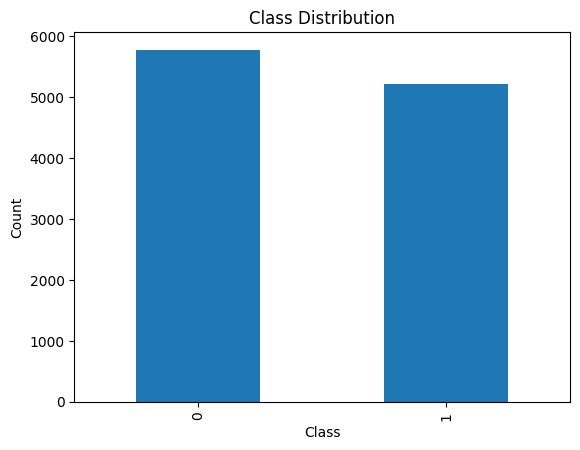

In [263]:
pd.Series(y).value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

## <u>**Class Distribution**</u>

Our test partition is 20% of the overall dataset. A rule of thumb when deciding the test size for the holdout method is that as the size of the dataset increases, the size of the test partition is able to become smaller while still maintaining the same margin of error for measuring the estimated accuracy. With the below calculated margins of error that are all small (none above 0.017), we obtain precise and reliable accuracy measures and taking into consideration our large dataset size (11,000 observations), we have sufficient arguments validating our choice of an 80/20 split. We will thus pursue the analysis with this split

<div style= "font-family: 'Georgia', serif;" >

## <u> **Base Models**</u>

### **Logistic Regression**

In [264]:
logreg = LogisticRegression(random_state=RANDOM_STATE_ID)

start_time = time.time()
logreg.fit(X_train_processed, y_train)
training_time = time.time() - start_time

y_pred_log = logreg.predict(X_test_processed)

accuracy_log = accuracy_score(y_test, y_pred_log)

print(accuracy_log)
print(training_time)




0.8181818181818182
0.0718069076538086


In [265]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_log = np.sqrt((accuracy_log*(1-accuracy_log))/n) 

ci_upper = accuracy_log + se_log*z
ci_lower = accuracy_log - se_log*z

print(ci_lower, ci_upper)
print(se_log*z)

0.8020646663080251 0.8342989700556114
0.016117151873793183


<div style= "font-family: 'Georgia', serif;" >


### **KNN**

In [266]:
knn = KNeighborsClassifier(n_neighbors=3)

start_time = time.time()
knn.fit(X_train_processed, y_train)
training_times["knn"] = time.time() - start_time

y_pred_knn = knn.predict(X_test_processed)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(accuracy_knn)


0.7995454545454546


In [267]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_knn = np.sqrt((accuracy_knn*(1-accuracy_knn))/n) 

ci_upper = accuracy_knn + se_knn*z
ci_lower = accuracy_knn - se_knn*z

print(ci_lower, ci_upper)
print(se_knn*z)

0.7828162895473836 0.8162746195435255
0.016729164998070947


<div style= "font-family: 'Georgia', serif;" >


### **Tree** 

In [268]:
tree = DecisionTreeClassifier()

start_time = time.time()
tree = tree.fit(X_train_processed, y_train)
training_times["tree"] = time.time() - start_time

y_pred_tree = tree.predict(X_test_processed)

accuracy_tree = accuracy_score(y_test, y_pred_tree)

print(accuracy_tree)

0.7868181818181819


In [269]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_tree = np.sqrt((accuracy_tree*(1-accuracy_tree))/n) 

ci_upper = accuracy_tree + se_tree*z
ci_lower = accuracy_tree - se_tree*z

print(ci_lower, ci_upper)
print(se_tree*z)

0.7697039659575906 0.8039323976787731
0.01711421586059131


<div style= "font-family: 'Georgia', serif;" >


### **Dummy Classifier**

In [270]:
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

print(accuracy_dummy)

0.519090909090909


<div style= "font-family: 'Georgia', serif;" >

## <u>**Model Comparison**</u>

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

## **Results**

| Model | Accuracy - no hyperparameter tuning |95 % Confidence Interval| Training time (s) |
|-------|--------|---------|----------|
|Logistic Regression|0.8182|[0.802, 0.834]|0.0529|
|KNN|0.7995|[0.783, 0.816]|2.1|0.0039|
|Decision Tree|0.785|[0.7604, 0.7951]|6.6|0.0802|




Dummy Classifier accuracy : 0.519

<br>
<br>
The model with the highest accuracy is the Logistic Regression (81.82%). It also has the lowest training time with 0.0529 seconds. On the other hand, the dummy classifier only achieved 51.9 % accuracy. The Logistic Regression improves prediction accuracy by almost 30 percentage points, meaning that it is much more performant than the dummy method. This reinforces the fact that our data is not imbalanced since the naïve baseline only correctly predicts the target variable a bit over 50 % of the time. 


<div style= "font-family: 'Georgia', serif;" >



## <u>**Hyper-parameter Tuning**</u>

<div style= "font-family: 'Georgia', serif;" >



### **Logistic Regression**

<div style= "font-family: 'Georgia', serif;" >



##### **Discrete Parametrical Space**

In [271]:

param_grid_discrete = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

start = time.time()
grid_discrete = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE_ID),
    param_grid_discrete,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_discrete.fit(X_train_processed, y_train)
grid_time_discrete = time.time() - start

print(f"Best params: {grid_discrete.best_params_}")
print(f"Best CV score: {grid_discrete.best_score_:.4f}")
print(f"Time: {grid_time_discrete:.2f}s")

y_pred_grid_discrete = grid_discrete.predict(X_test_processed)
acc_grid_discrete = accuracy_score(y_test, y_pred_grid_discrete)
print(f"Test accuracy: {acc_grid_discrete:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

Best params: {'C': 100, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.8322
Time: 6.97s
Test accuracy: 0.8159


In [272]:

#RandomizedSearchCV with discrete values
start = time.time()
random_discrete = RandomizedSearchCV(
    LogisticRegression(random_state=RANDOM_STATE_ID),
    param_grid_discrete,  
    n_iter=30,  
    cv=5,
    scoring='accuracy',
    random_state=RANDOM_STATE_ID,
    n_jobs=-1
)
random_discrete.fit(X_train_processed, y_train)
random_time_discrete = time.time() - start

print(f"Best params: {random_discrete.best_params_}")
print(f"Best CV score: {random_discrete.best_score_:.4f}")
print(f"Time: {random_time_discrete:.2f}s")

y_pred_random_discrete = random_discrete.predict(X_test_processed)
acc_random_discrete = accuracy_score(y_test, y_pred_random_discrete)
print(f"Test accuracy: {acc_random_discrete:.8f}")

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

Best params: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 100}
Best CV score: 0.8322
Time: 2.59s
Test accuracy: 0.81590909


<div style= "font-family: 'Georgia', serif;" >



##### **Continuous Parametrical Space**

In [273]:
param_dist_continuous = {
    'C': loguniform(1e-4, 1e2),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': randint(100, 2000)  
}

start = time.time()
random_continuous = RandomizedSearchCV(
    LogisticRegression(random_state=RANDOM_STATE_ID),
    param_dist_continuous,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=RANDOM_STATE_ID,
    n_jobs=-1
)
random_continuous.fit(X_train_processed, y_train)
random_time_continuous = time.time() - start

print(f"Best params: {random_continuous.best_params_}")
print(f"Best CV score: {random_continuous.best_score_:.4f}")
print(f"Time: {random_time_continuous:.2f}s")

y_pred_random_continuous = random_continuous.predict(X_test_processed)
acc_random_continuous = accuracy_score(y_test, y_pred_random_continuous)
print(f"Test accuracy: {acc_random_continuous:.8f}")

Best params: {'C': np.float64(50.46250566733664), 'max_iter': 1503, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV score: 0.8323
Time: 3.47s
Test accuracy: 0.81590909


In [274]:
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [275]:
def objective(trial):
    C = trial.suggest_float('C', 0.0001, 100, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    
    model = LogisticRegression(C=C, solver=solver, random_state=RANDOM_STATE_ID)
    model.fit(X_train_processed, y_train)
    
    return accuracy_score(y_test, model.predict(X_test_processed))

start = time.time()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

optuna_logistic_time = time.time() - start

print("Time", optuna_logistic_time)
print("Best:", study.best_params)
print(f"Accuracy score:, {study.best_value:.3f}")



/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
   

Time 1.494014024734497
Best: {'C': 0.0495828472449947, 'solver': 'lbfgs'}
Accuracy score:, 0.820


In [276]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_log_tuned = np.sqrt((study.best_value*(1-study.best_value))/n) 

ci_upper = study.best_value + se_log_tuned*z
ci_lower = study.best_value - se_log_tuned*z

print(se_log_tuned*z)
print(ci_lower, ci_upper)

0.016069973732012077
0.8034754808134426 0.8356154282774666


<div style= "font-family: 'Georgia', serif;" >



### **KNN**

<div style= "font-family: 'Georgia', serif;" >



##### **Discrete Parametrical Space**

In [277]:
param_grid_knn_discrete = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

start = time.time()
grid_knn_discrete = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn_discrete,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
)
grid_knn_discrete.fit(X_train_processed, y_train)
grid_knn_time_discrete = time.time() - start

print(f"Best params: {grid_knn_discrete.best_params_}")
print(f"Best CV score: {grid_knn_discrete.best_score_:.4f}")
print(f"Time: {grid_knn_time_discrete:.2f}s")

y_pred = grid_knn_discrete.predict(X_test_processed)
accuracy_knn_discrete = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy_knn_discrete:.4f}")


Best params: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'distance'}
Best CV score: 0.8108
Time: 10.12s
Test accuracy: 0.8191


In [278]:
start = time.time()
random_knn_discrete = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_grid_knn_discrete,
    n_iter=25,
    cv=5,
    scoring='accuracy',
    random_state=RANDOM_STATE_ID,
    n_jobs=-1,
    verbose=1
)
random_knn_discrete.fit(X_train, y_train)
random_knn_time_discrete = time.time() - start

print(f"Best params: {random_knn_discrete.best_params_}")
print(f"Best CV score: {random_knn_discrete.best_score_:.4f}")
print(f"Time: {random_knn_time_discrete:.2f}s")

y_pred_rs = grid_knn_discrete.predict(X_test_processed)
accuracy_knn_discrete_rs = accuracy_score(y_test, y_pred_rs)
print(f"Test accuracy: {accuracy_knn_discrete_rs:.4f}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits


Best params: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'manhattan'}
Best CV score: 0.7516
Time: 20.33s
Test accuracy: 0.8191


<div style= "font-family: 'Georgia', serif;" >



##### **Continuous Parametrical Space**

In [279]:
param_dist_knn_continuous = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean','minkowski','manhattan']  
}

start = time.time()
random_search_knn_continuous = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_dist_knn_continuous,
    n_iter=20, 
    cv=5,
    random_state=RANDOM_STATE_ID,
    n_jobs=-1
)

random_search_knn_continuous.fit(X_train_processed, y_train)
random_knn_time_continuous = time.time() - start

print("Best parameters:", random_search_knn_continuous.best_params_)
print("Best score:", random_search_knn_continuous.best_score_)

rs_tuned_knn = random_search_knn_continuous.predict(X_test_processed)
accuracy_tuned_knn = accuracy_score(rs_tuned_knn, y_test)

print("Test accuracy:", accuracy_tuned_knn)
print(f"Time: {random_knn_time_continuous:.2f}s")



Best parameters: {'weights': 'distance', 'n_neighbors': 29, 'metric': 'minkowski'}
Best score: 0.8113636363636363
Test accuracy: 0.8140909090909091
Time: 4.58s


In [280]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 50)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    model.fit(X_train_processed, y_train)
    
    return accuracy_score(y_test, model.predict(X_test_processed))

start = time.time()
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective_knn, n_trials=50)

optuna_knn_time = time.time() - start

print("Time:", optuna_knn_time)
print("Best:", study_knn.best_params)
print("Score:", study_knn.best_value)

Time: 2.7407758235931396
Best: {'n_neighbors': 9, 'weights': 'distance'}
Score: 0.8218181818181818


In [281]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_knn_tuned = np.sqrt((study_knn.best_value*(1-study_knn.best_value))/n) 

ci_upper = study_knn.best_value + se_knn_tuned*z
ci_lower = study_knn.best_value - se_knn_tuned*z

print(ci_lower, ci_upper)

0.8058275988644368 0.8378087647719268


<div style= "font-family: 'Georgia', serif;" >


### **Decision Tree**

In [282]:
param_dist_tree = {
     'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}
tree = DecisionTreeClassifier(random_state=RANDOM_STATE_ID)

#Tuning using RandomizedSearchCV
random_search_tree = RandomizedSearchCV(tree, param_distributions=param_dist_tree, 
                                   cv=3, scoring='accuracy',
                                   n_iter=50, random_state=RANDOM_STATE_ID,
                                   n_jobs=1
)

start_time = time.time()
random_search_tree.fit(X_train_processed, y_train)
tuning_times["tree"] = time.time() - start_time
best_params= random_search_tree.best_params_
best_score = random_search_tree.best_score_

print(f"Best Parameters (Random Search): {best_params}")
print(f"Best Score (Random Search): {best_score}")

Best Parameters (Random Search): {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 18, 'min_samples_split': 3}
Best Score (Random Search): 0.8294310648952874


In [283]:
tuned_tree = random_search_tree.best_estimator_
y_pred_tuned_tree = tuned_tree.predict(X_test_processed)

accuracy_tree_tuned = accuracy_score(y_pred_tuned_tree, y_test)

print(accuracy_tree_tuned)
print(tuning_times)


0.8368181818181818
{'tree': 4.079809904098511}


In [284]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_tree_tuned = np.sqrt((accuracy_tree_tuned*(1-accuracy_tree_tuned))/n) 

ci_upper = accuracy_tree_tuned + se_tree_tuned*z
ci_lower = accuracy_tree_tuned - se_tree_tuned*z

print(ci_lower, ci_upper)

0.8213764442036524 0.8522599194327112




<div style= "font-family: 'Georgia', serif;" >

## <u> **Hyper-parameter tuning dicussion** </u>



<div style= "font-family: 'Georgia', serif;" >

### **Results**

| Model|Best Accuracy (Discrete Parametrical Space) | Best Accuracy (Continuous Parametrical Space) | Discrete Hyperparameter tuning time (s)|Continuous Hyperparameter tuning time (s)  |
|-------|--------|---------|----------|-------|
|Logistic Regression|0.8159 (GridSearch)|0.82 (Optuna)|3.35|1.75|
|KNN|0.8191 (GridSearch)|0.8218 (Optuna)|10.68|3.22|


<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">

From the above table, we clearly see that hyper-parameter tuning using continuous parametrical space offers the greatest increase in accuracy for the best two base models (KNN and Logistic Regression). In the Continuous Parametrical Space, it is the Optuna method that performs better over the RandomizedSearch method, which is why we decided to only include the former in our results' table. With the results, we decide to use continuous parametrical space for future hyperparameter tuning.

Furthermore, KNN displays the overall highest accuracy of our base models with 82.18 % . It also shows the greatest improvement in accuracy score compared to the Logistic Regression (2.79 % VS 0.22 % accuracy improvement). 

<div style= "font-family: 'Georgia', serif;" >

## <u>**Advanced Models**</u>

<div style= "font-family: 'Georgia', serif;" >

### **SVM**

In [285]:
from sklearn.svm import SVC

svm_model = SVC(random_state=RANDOM_STATE_ID)

start_time = time.time()

svm_model.fit(X_train_processed, y_train)
training_time = time.time() - start_time

y_pred_svm = svm_model.predict(X_test_processed)

accuracy_svm = accuracy_score(y_pred_svm, y_test)

print("SVM Accuracy Score:", accuracy_svm)
print(training_time)

SVM Accuracy Score: 0.8563636363636363
1.7182250022888184


In [286]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_svm = np.sqrt((accuracy_svm*(1-accuracy_svm))/n) 

ci_upper = accuracy_svm + se_svm*z
ci_lower = accuracy_svm- se_svm*z

print(ci_lower, ci_upper)

0.8417079541076244 0.8710193186196482


In [287]:
#SVM tuning using Optuna

from sklearn.svm import SVC

def objective_svm(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)               #Used AI for the suggest line.
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf']) 
    gamma = trial.suggest_float('gamma', 0.0001, 1, log=True) 
    
    model = SVC(C=C, kernel=kernel, gamma=gamma, random_state=RANDOM_STATE_ID)
    model.fit(X_train_processed, y_train)  
    
    return accuracy_score(y_test, model.predict(X_test_processed))

start = time.time()
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=30)
svm_time = time.time() - start

print("Best params:", study_svm.best_params)
print("Best score:", f"{study_svm.best_value:.4f}")
print("Time:", f"{svm_time:.2f}s")
                  

Best params: {'C': 13.775819585451138, 'kernel': 'rbf', 'gamma': 0.011632487356139776}
Best score: 0.8609
Time: 87.35s


In [288]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_svm = np.sqrt((study_svm.best_value*(1-study_svm.best_value))/n) 

ci_upper = study_svm.best_value + se_svm*z
ci_lower = study_svm.best_value- se_svm*z

print(ci_lower, ci_upper)

0.8464489424862109 0.875369239331971


<div style= "font-family: 'Georgia', serif;" >

### **Random Forest Classifier**


In [289]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=RANDOM_STATE_ID)
start_time = time.time()

rf.fit(X_train_processed, y_train)
training_times["rf"] = time.time() - start_time

y_pred_rf= rf.predict(X_test_processed)

accuracy_rf = accuracy_score(y_pred_rf, y_test)

print("Random Forest Accuracy score:", accuracy_rf)

Random Forest Accuracy score: 0.8522727272727273


In [290]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_rf = np.sqrt((accuracy_rf*(1-accuracy_rf))/n) 

ci_upper = accuracy_rf + se_rf*z
ci_lower = accuracy_rf- se_rf*z

print(ci_lower, ci_upper)

0.8374453490231826 0.867100105522272


<div style= "font-family: 'Georgia', serif;" >

### **XGBoost**

In [291]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=100,        
    max_depth=6,             
    learning_rate=0.1,      
    objective='binary:logistic', 
    random_state=RANDOM_STATE_ID
)

start_time = time.time()
xgb_model.fit(X_train_processed, y_train)
training_times = time.time() - start_time
y_pred_xgb = xgb_model.predict(X_test_processed)

accuracy_xgb = accuracy_score(y_pred_xgb, y_test)

print("XGBoost accuracy score:", accuracy_xgb)
print(training_times)



XGBoost accuracy score: 0.8563636363636363
0.363527774810791


In [292]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_xgb = np.sqrt((accuracy_xgb*(1-accuracy_xgb))/n) 

ci_upper = accuracy_xgb + se_xgb*z
ci_lower = accuracy_xgb - se_xgb*z

print(ci_lower, ci_upper)

0.8417079541076244 0.8710193186196482


In [293]:
#Tuning XGBoost with Optuna

def objective_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        random_state=RANDOM_STATE_ID
    )
    model.fit(X_train_processed, y_train)
    
    return accuracy_score(y_test, model.predict(X_test_processed))

start = time.time()
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)
xgb_time = time.time() - start

print("Best params:", study_xgb.best_params)
print("Best score:", f"{study_xgb.best_value:.4f}")
print("Time:", f"{xgb_time:.2f}s")

Best params: {'max_depth': 4, 'learning_rate': 0.26299808743114744, 'n_estimators': 200}
Best score: 0.8623
Time: 11.73s


In [294]:
#Confidence Interval

n = len(y_test)
z = 1.96

se_xgb_tuned = np.sqrt((study_xgb.best_value*(1-study_xgb.best_value))/n) 

ci_upper = study_xgb.best_value + se_xgb_tuned*z
ci_lower = study_xgb.best_value - se_xgb_tuned*z

print(ci_lower, ci_upper)

0.8478722452340887 0.8766732093113659


<div style= "font-family: 'Georgia', serif;" >

## <u>**Results**</u>

| Model | Accuracy - no hyperparameter tuning |95 % Confidence Interval| Accuracy - tuned hyperparameters |95% Confidence Interval| Accuracy Improvement (%)| Training time (s) | Hyperparameter tuning time (s)|
|-------|--------|---------|----------|-----------|------------|--------|-------|
|Logistic Regression|0.8182|[0.802, 0.834]|0.82|[0.799, 0.8317]|0.22||1.75|
|KNN|0.7995|[0.783, 0.816]|0.8218|[0.800, 0.8326]|2.79|0.0039|3.22|
|Decision Tree|0.785|[0.7604, 0.7951]|0.8368|[0.8214, 0.8523]|6.6|0.0802|4.9904|
|SVM|0.8564|[0.8417, 0.871]|0.86|[0.8455, 0.8745]|0.42|1.48|103.9|
|Random Forest|0.8522|[0.837, 0.867]|/|/|/|1.02|/|
|XGboost|0.8564|[0.8417, 0.871]|0.8645|[0.85, 0.879]|0.946|0.174|9.57|

<div style="max-width: 1000px; font-family: 'Georgia', serif; font-size: 14px; line-height: 1.6;">


## <u>**Comments**</u>

### <u>**Base Models**</u>
From the above table, we note that out off the base models, the logistic regression performed the best with an accuracy score of 81.8 %. Then came the KNN method and finally the Decision Tree with accuracies of 79.95% and 78.5% respectively. 



#### **After hyperparameter tuning** 
After hyperparameter tuning, the KNN method achieved both the highest accuracy with 83.68% 
and the greatest improvement in accuracy (6.6%) compared to the Logistic Regression. Hyper-parameter tuning was slightly slower for KNN (3.22 seconds vs 1.75 seconds) The Logistic Regression model only experienced a slight increase in accuracy after tuning the hyperparameters (0.22%). 

Out of curiosity, we also decided to tune the Decision Tree model even though it performed worst out of the base models. Surprisingly, it ultimately displayed the highest improvement in accuracy  (6.6%) and best overall accuracy for the base models (83.68%).   


### <u>**Advanced Models**</u>

All three of the  (untuned) advanced models performed better than the base models before and after hyperparameter tuning. They all present similar accuracy scores with SVM and XGboost achieving a slightly higher (and identical) accuracy of 85.64 %. 

We checked the confusion matrix for XGboost and SVM and noticed that they had different numbers of correct predictions for class 0 and class 1 (has the client subscribed a term deposit?) but overall achieved the same number of total correct predictions, which explains why they achieved identical accuracy scores.

#### **After hyperparameter tuning**

We decided to tune the SVM and XGBoost models as they presented the highest accuracy of the advanced models. XGBoost achieved the higher accuracy score increase of the 2 (0.946%), with a final accuracy of 86.45%. It also had the faster hyperparameter tuning time with 9.57 seconds compared to 103.9 seconds for SVM (only improving accuracy by 0.42%)

### <u>**Conclusion**</u>

We conclude that we should use the more advanced prediction models for this problem as they all presented higher accuracy scores than the base models. We would favour the XGboost model as it presented the highest overall accuracy of all models (tuned and untuned) and as tuning was faster for that specifc model. 


</div>


<div style= "font-family: 'Georgia', serif;" >


## <u>**Final Model**</u>

In [295]:
#Load test dataset

test_set = pd.read_pickle(COMPETITION_DATA_PATH)

print(test_set.columns)

# make predictions about this using the best method

# save final model (in notes)
# save predictions in a file (pkl)

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')
